In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from pandas import Series, DataFrame
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
# CSV of publically traded healthcare companies as classified by GIC subindustry codes
df = pd.read_csv('healthcare_fundamentals_v3.csv') #update w/ latest version

#To-DO:
#normalize
#impute missing values?
#add H-measure
#customize loss matrix for confusion matrix
#rebalance bt weight the loss of each training example based on the proportion of its label

C:\Users\Hannah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (23,33,37,955,956,957,962,976,977) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#list(df.columns) #cusip, gvkey, lpermno, sic
df['cik']

0         319126.0
1         319126.0
2         319126.0
3         319126.0
4         319126.0
           ...    
14060    1567529.0
14061    1138776.0
14062    1138776.0
14063    1553846.0
14064    1553846.0
Name: cik, Length: 14065, dtype: float64

In [4]:
# Get CIK list from healthcare_fundamentals file
cik_list = str(list(df['cik'])).strip('\'').strip('[').strip(']').split(', ')

In [5]:
# Write to txt file to look up relevant companies in Audit Analytics database
file = open('healthcare_cik.txt','w')
for i in df['cik']:
    file.write(str(i))
    file.write('\n')
file.close()

In [6]:
# Bankrupt healthcare companies
# TO-DO: filter for public companies
df_bankrupt = pd.read_csv('healthcare_bankrupt_audit_analytics_v2.csv')
len(df_bankrupt)
df_bankrupt.columns

Index(['COMPANY_FKEY', 'BANK_KEY', 'SUBSID_NAME', 'BANKRUPTCY_TYPE',
       'LAW_COURT_FKEY', 'COURT_TYPE_CODE', 'COURT_NAME', 'COURT_S_NAME',
       'COURT_LOC_STREET', 'COURT_LOC_CITY',
       ...
       'HIWATER_INCMST_REVFY', 'HIWATER_INCMST_NETINC_QTR_DATE',
       'HIWATER_INCMST_NETINC_QTR', 'HIWATER_INCMST_NETINC_TTM_DATE',
       'HIWATER_INCMST_NETINC_TTM', 'HIWATER_INCMST_NETINC_FY_DATE',
       'HIWATER_INCMST_NETINC_FY', 'NAME_CHANGE_DATE1', 'NAME_CHANGE_DATE2',
       'NAME_CHANGE_DATE3'],
      dtype='object', length=464)

In [7]:
df_bankrupt_ch_11 = df_bankrupt[df_bankrupt['BANKRUPTCY_TYPE']==11]
len(df_bankrupt_ch_11)

125

In [8]:
relevant_columns = df_bankrupt[['COMPANY_FKEY','FILE_DATE']]
#list(df_bankrupt.columns)
df['cik'][:5]

0    319126.0
1    319126.0
2    319126.0
3    319126.0
4    319126.0
Name: cik, dtype: float64

In [9]:
# COMPANY_FKEY is CIK
df_bankrupt['COMPANY_FKEY'][:5]

0     2034
1    19411
2    57055
3    64892
4    69623
Name: COMPANY_FKEY, dtype: int64

In [10]:
df_bankrupt['COMPANY_FKEY'].nunique()

182

In [11]:
#filter for 2000-2010
mask = (pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year >1999) &  (pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year < 2011)

In [12]:
df_bankrupt_2000 = df_bankrupt[mask]

In [51]:
df_bankrupt_2000[:3]

,COMPANY_FKEY,BANK_KEY,SUBSID_NAME,BANKRUPTCY_TYPE,LAW_COURT_FKEY,COURT_TYPE_CODE,COURT_NAME,COURT_S_NAME,COURT_LOC_STREET,COURT_LOC_CITY,...,HIWATER_INCMST_REVFY,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3
1,19411,196,NaN,11,148,1,New York Southern Bankruptcy Court,NY SBC,NaN,NaN,...,1.844645e+09,2003-12-31,499948000.0,2004-09-30,567866000.0,2003-12-31,499948000.0,2014-07-01,1996-02-14,NaN
4,69623,1324,NaN,11,148,1,New York Southern Bankruptcy Court,NY SBC,NaN,NaN,...,NaN,2002-02-28,1370815.0,2002-02-28,1370815.0,2002-02-28,1370815.0,2004-07-20,NaN,NaN
5,71478,1565,NaN,7,104,1,California Northern Bankruptcy Court,CA NBC,NaN,NaN,...,NaN,2004-12-31,-2214000.0,2005-06-30,-10450000.0,2007-12-31,-4213000.0,2001-11-13,2000-03-31,NaN


In [14]:
df_merge = pd.merge(df, df_bankrupt_2000, left_on = 'cik', right_on = 'COMPANY_FKEY', suffixes = ('_fundam', '_bank'), how = 'left')
df_merge['cik'].nunique()

1788

In [15]:
# df_merge_11 = df_merge[df_merge['BANKRUPTCY_TYPE']==11]
# df_merge_11

In [52]:
df_merge[:3]

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupted,current_ratio,wc_ta,totaldebt_totalasset,ROA,research_sale
0,1021,P,01,NU,NaN,NaN,03/20/1999,E,06/30/2000,2000.0,...,NaN,NaN,NaN,NaN,0,3.460931,0.482943,0.436768,-0.069607,0.018804
1,1021,P,01,NU,NaN,NaN,03/20/1999,E,06/30/2001,2001.0,...,NaN,NaN,NaN,NaN,0,3.175550,0.515229,0.464968,-0.201274,0.019001
2,1021,P,01,NU,NaN,NaN,03/20/1999,E,06/30/2002,2002.0,...,NaN,NaN,NaN,NaN,0,2.393390,0.440382,0.366115,0.010701,0.024892


In [17]:
df_test = df_merge[df_merge['cik'] ==815508]

In [53]:
df_test[:3]

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_REVFY,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3
9302,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2000,2000.0,...,700000.0,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN
9303,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2001,2001.0,...,700000.0,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN
9304,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2002,2002.0,...,700000.0,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN


In [19]:
mask = pd.to_datetime(df_merge['datadate']).dt.year + 1 == pd.to_datetime(df_merge['BANK_BEGIN_DATE']).dt.year

df_merge['bankrupted'] = np.where(mask, 1,0)

In [54]:
df_merge['bankrupted'][:3]

0    0
1    0
2    0
Name: bankrupted, dtype: int32

In [21]:
mask = pd.to_datetime(df_merge['datadate']).dt.year + 1 == pd.to_datetime(df_merge['BANK_BEGIN_DATE']).dt.year
df_merge[mask]

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupted
373,2903,C,01,LC,22518.0,6193.0,08/04/1993,08/29/2008,03/31/2008,2007.0,...,2005-03-31,589000.0,2002-03-31,1157000.0,2002-03-31,NaN,NaN,NaN,NaN,1
376,2940,C,01,LC,77854.0,25268.0,08/07/1992,10/08/2002,09/30/2002,2002.0,...,2003-12-31,499948000.0,2004-09-30,567866000.0,2003-12-31,499948000.0,2014-07-01,1996-02-14,NaN,1
445,3171,P,01,LC,24548.0,5308.0,06/30/1982,07/20/2009,12/31/2008,2008.0,...,2007-06-30,16277000.0,2000-08-31,-2816050.0,2000-08-31,NaN,2004-04-08,NaN,NaN,1
596,4228,C,01,LC,84799.0,15464.0,05/09/1997,04/09/2001,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-14,NaN,NaN,1
972,7133,C,01,LU,51992.0,6296.0,08/18/1983,05/24/2001,12/31/2000,2000.0,...,2005-12-31,357000.0,2002-12-31,-1278000.0,2002-12-31,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11733,157758,P,01,LC,90128.0,45084.0,04/16/2004,04/28/2008,12/31/2007,2007.0,...,2007-06-30,-1617000.0,2007-06-30,-18960000.0,2007-12-31,-12695000.0,NaN,NaN,NaN,1
12193,162956,P,01,LC,90945.0,47874.0,10/28/2005,11/03/2008,09/30/2007,2007.0,...,2004-09-30,0.0,2009-09-30,-8061727.0,2009-09-30,0.0,NaN,NaN,NaN,1
12580,165857,P,01,LC,91074.0,50193.0,01/26/2006,11/20/2009,12/31/2008,2008.0,...,2007-12-31,5466000.0,2007-12-31,-63232000.0,2007-12-31,5466000.0,NaN,NaN,NaN,1
12608,166200,P,01,LC,91820.0,51809.0,02/02/2007,12/20/2010,12/31/2009,2009.0,...,2005-12-31,0.0,2007-12-31,-59825181.0,2007-12-31,-21654318.0,NaN,NaN,NaN,1


In [22]:
df_merge['cik'].nunique()

1788

In [23]:
pd.to_datetime(df_merge['datadate']).dt.year + 1

0        2001
1        2002
2        2003
3        2004
4        2005
         ... 
14070    2011
14071    2010
14072    2011
14073    2010
14074    2011
Name: datadate, Length: 14075, dtype: int64

In [24]:
pd.to_datetime(df_test['BANK_BEGIN_DATE']).dt.year

9302    2009
9303    2009
9304    2009
9305    2009
9306    2009
9307    2009
9308    2009
9309    2009
9310    2009
Name: BANK_BEGIN_DATE, dtype: int64

In [25]:
df_test['BANK_BEGIN_DATE']

9302    2009-07-16
9303    2009-07-16
9304    2009-07-16
9305    2009-07-16
9306    2009-07-16
9307    2009-07-16
9308    2009-07-16
9309    2009-07-16
9310    2009-07-16
Name: BANK_BEGIN_DATE, dtype: object

In [26]:
# TO-DO: replace w/ Joseph's finratio data
# augument different ratio 
#Current Ratio 
df_merge['current_ratio']= df_merge['act']/df_merge['lct']
# Working capital to Total Asset 
df_merge['wc_ta']= df_merge['wcap']/df_merge['at']
#Debt to Asset Ratio
df_merge['totaldebt_totalasset']= df_merge['dt']/df_merge['at']
# ROA 
df_merge['ROA']= df_merge['ni']/df_merge['at']
# RD to sales ratio 
df_merge['research_sale']= df_merge['xrd']/df_merge['sale']

In [27]:
work= df_merge[['current_ratio','wc_ta','totaldebt_totalasset','ROA','research_sale','bankrupted','datadate']]

In [28]:
work=work.replace([np.inf, -np.inf], np.nan)

In [29]:
work=work.dropna()

In [30]:
mask_test = pd.to_datetime(work['datadate']).dt.year >=2006
train=work[~mask_test]
test=work[mask_test]

In [31]:
y_train= train['bankrupted']
train= train.drop(columns=['bankrupted', 'datadate'])


In [32]:
x_train= train

## Random Forest

In [33]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')

rgr=clf.fit(x_train, y_train)

In [34]:
pred_train=rgr.predict(x_train)
accuracy_score(pred_train, y_train)

0.8953387627794143

In [35]:
y_test= test['bankrupted']
test= test.drop(columns=['bankrupted', 'datadate'])
x_test= test

In [36]:
pred_test=rgr.predict(x_test)
accuracy_score(pred_test, y_test)

0.8903061224489796

In [37]:
pred_test.sum()

469

In [38]:
pred_test

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

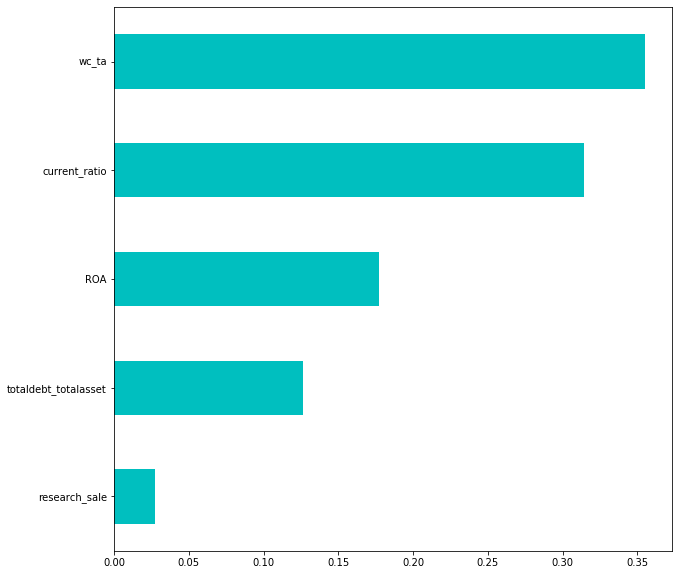

In [59]:
feat_importances = pd.Series(rgr.feature_importances_, index=x_train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values().plot(kind='barh',color='c')
#feat_importances.sort_values(ascending=False)

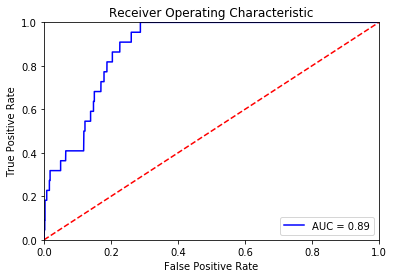

In [60]:
# UNFINISHED
import sklearn.metrics as metrics
y_pred_proba = clf.predict_proba(x_test)[::,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# AUROC RF
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression 

In [40]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5,class_weight='balanced')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_pred=logreg.predict(x_test)

In [42]:
accuracy_score(y_pred, y_test)

0.7200834879406308

In [43]:
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [44]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

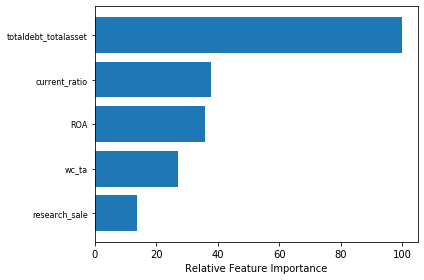

In [61]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

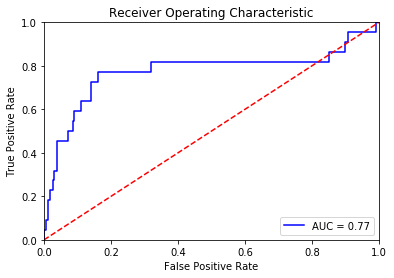

In [62]:
# UNFINISHED
import sklearn.metrics as metrics
y_pred_proba = logreg.predict_proba(x_test)[::,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt


# AUROC Logreg
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Precision and Recall curve 

In [46]:
import numpy as np
from sklearn.metrics import precision_recall_curve

In [47]:
y_score = logreg.decision_function(x_test)

In [48]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.04


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(logreg, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))